**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 14.6 MB/s 
     |████████████████████████████████| 743 kB 57.8 MB/s 
     |████████████████████████████████| 4.9 MB 13.8 MB/s 
     |████████████████████████████████| 86 kB 254 kB/s 
     |████████████████████████████████| 1.1 MB 23.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=c7948c2ca6ba35168e6b00b7b7afe49841a124e02465bda1bd4f1e6abe410e0d
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=7c3532f39f399fbd365741be6398295c5fb9ff36ef101e35b2d9aa84934622ff
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import matplotlib as mpl
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
labels_params = {'font_family': 'TH Sarabun New', 'alpha':.8, 'font_size':12}
mpl.rc('font', family='TH Sarabun New',size = 7)

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [4]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [5]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [6]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993825,  0.01941087,  0.03787041, ..., -0.03488846,
         0.06299512,  0.04635989],
       [ 0.00634238,  0.00814594,  0.03071934, ..., -0.01478722,
        -0.03080936, -0.03316408],
       [ 0.06336872, -0.02027135, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439984],
       ...,
       [ 0.08775924,  0.03609739,  0.01263063, ..., -0.03102781,
        -0.03361675,  0.01928869],
       [ 0.05691193,  0.0538169 , -0.03995752, ..., -0.06598806,
        -0.05390476, -0.01037723],
       [ 0.07770479,  0.0508063 ,  0.02680679, ..., -0.0061413 ,
        -0.01313565,  0.02236262]], dtype=float32)

In [7]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

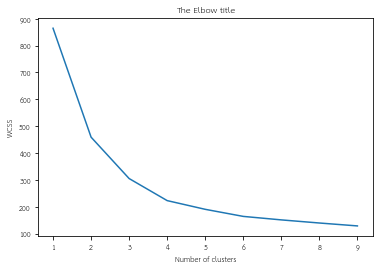

In [8]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [9]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [10]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [11]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


In [12]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [13]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [14]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [15]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [16]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [17]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [18]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-','\n', 'ร้าน','กิน','ซื้อ','ทาน', 'ผม','กก','สวัสดี', 'สาขา','เรา','ฉัน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก","ดี","ไม่ดี","อร่อย","ไม่อร่อย","ซ้ำ"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [19]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [20]:
#results of tokenization
pd.set_option('display.max_colwidth', 50)
df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, นึง, เด, Artof...","[(ร้านกาแฟ, 23), (กาแฟ, 19), (ชอบ, 7), (คาเฟ่,..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (อร่อย, 6), (ซอย, 6), (อาหาร..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(อร่อย, 8), (รีวิว, 6), (อาหาร, 5), (บ้าน, 5)..."


In [21]:
#show top keywords of each cluster

top_N_words = 25

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 23), ('กาแฟ', 19), ('ชอบ', 7), ('คาเฟ่', 5), ('น่ารัก', 5), ('น', 5), ('นั่ง', 5), ('เจอ', 5), ('แวะ', 5), ('บรรยากาศ', 5), ('ชั้น', 5), ('คน', 4), ('นึง', 4), ('อ', 4), ('เบเกอรี่', 4), ('พาย', 4), ('วัง', 4), ('แนว', 4), ('กร้าน', 4), ('เม', 4), ('ซอน', 4), ('ดี', 4), ('ตกแต่ง', 4), ('ตั้งอยู่', 4), ('เด', 3)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 11), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ราคา', 5), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('รีวิว', 3), ('ไร้', 3), ('าน', 3), ('ส', 3), ('ยำ', 3), ('รา', 3), ('เก่าแก่', 3), ('รอบ', 3), ('เป็ด', 3), ('เมนู', 3), ('ห', 3), ('ดีล', 3), ('กาแฟ', 3), ('เนื้อ', 2), ('ถนน', 2)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('รีวิว', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('แวะ', 2), ('เติม', 2), ('นขา', 2), ('ชาเขียว', 2), ('

**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [22]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [23]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

df_Agglomerative

,Agglomerative ID,texts
0,0,['เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึง...
1,1,['ประโยชน์ของน้ำแตงโมปั่น\nแตงโม มีมากมายหลายพ...
2,2,['วันนี้ดิช้ันมาทบนอาหารเวลา5 โมงเย็น ที่ร้านแ...
3,3,['เรื่องขนม ไม่ค่อยสันทัด ดังนั้นขอreviewเฉพาะ...


In [24]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [25]:
#show top keywords of each cluster

top_N_words = 25

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 480), ('รสชาติ', 407), ('ดี', 342), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273), ('(', 270), ('ชา', 262), (')', 250), ('บาท', 242), ('ชอบ', 229), ('คน', 215), ("','", 215), ('หวาน', 206), ('นั่ง', 201), ('จาน', 196), ('ลอง', 178), ('นะคะ', 154), ('บรรยากาศ', 151), ('นม', 149), ('ดู', 147), ('-', 142), ('เค้า', 136)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3), ('อาหาร', 3), ('ร่างกาย', 3), ('เมล็ด', 2), ('มีรส', 2), ('หวาน', 2), ('เย็น', 2), ('ยังมี', 2), ('วิตามิน', 2), ('สีแดง', 2), ('ผลไม้', 2), ('กระหาย', 2), ('ดี', 2), ('สำหรับ', 2), ('ล้าง', 2), ('โรค', 2), ("['", 1)]

Cluster ID : 2

Most common words include : [('ดิชั้น', 4), ('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ("['", 1), ('ดิ', 1), ('ช้ัน', 1), ('ทบ', 1), ('น', 1), ('อาหาร', 1), ('เวลา', 1), ('โมง', 1

**Step 4 - result discussion**

## ผลลัพธ์
    Cluster 0 : กลุ่มที่มีจำนวนคำที่เจอเยอะที่สุด 
    Cluster 1 : กลุ่มที่มีจำนวนคำที่เจอเยอะเป็นอันดับที่ 2
    Cluster 2 : กลุ่มที่มีจำนวนคำที่เจอเยอะเป็นอันดับที่ 3
    Cluster 3 : กลุ่มที่มีจำนวนคำที่เจอน้อยที่สุด
  
###ประเภทร้านของแต่ละ Cluster

    Cluster ID 0 : คาเฟ่
                   ค่าเฟ่ที่มีบรรยากาศดี มีเมนูทั้งเครื่องดื่มและ ขนม ที่อาจจะได้รับรีวิวเยอะๆหรือกำลังเป็นกระแส เนื่องจากมี keyword เกี่ยวกับคำว่า ลอง,ครั้งแรก 
    Cluster ID 1 : ร้านอาหารไทย/ร้านน้ำผลไม้
                   น่าจะเป็นร้านอาหารไทยเก่าแก่ ที่อาจจะมีการขายผลไม้หรือเครื่องดื่มจากผลไม้ด้วย รีวิวที่ได้ ค่อนข้างเน้นไปที่อาหารรสชาติดี
    Cluster ID 2 : ร้านชานมไข่มุก/เครื่องดื่ม
                   ร้านชานมไข่มุกที่น่าจะมีหลายสาขา keyword ส่วนใหญ่พูดถึงชาชนิดต่างๆ นม ไข่มุก และอาจจะมีปัญหาเรื่องพนักงาน
    Cluster ID 3 : ร้านกาแฟ
                   ร้านกาแฟ/คาเฟ่ด้านกาแฟโดยเฉพาะ เนื่องจาก keyword ส่วนใหญ่เกี่ยวข้องกับกาแฟ เช่น ร้านกาแฟ กาแฟ สายพันธุ์ เมล็ด
        